### Road Lane Line Detection using Computer Vision  

#### Overview  
When we drive, we use our eyes to decide where to go. The lines on the road that show us where the lanes are act as our constant reference for where to steer the vehicle. Naturally, one of the first things we would like to do in developing a self-driving car is to automatically detect lane lines using an algorithm. <br>

To detect lane lines we will be using Python and OpenCV. OpenCV means "Open-Source Computer Vision", which is a package that has many useful tools for analyzing images.  <br>
  
The tools we have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection. We will build a pipeline to detect the line segments in images, then average/extrapolate them and draw them onto the images for display. Once we do this successfully for images, we will apply this to video.  
  

#### Our strategy to solve this:
1. Detect lane lines manually using numpy & matplotlib <br>
   i. Color selection (select lane colors - white and yellow) <br>
   ii. Region masking (select region of interest where the lane lines appear) <br>
2. Detect road lane lines using OpenCV  <br>
   i. Gray scale <br>
   ii. Gaussian Smoothing <br>
   iii. Canny Edge Detection <br>
   iv. Region Masking <br>
   v. Hough Transform <br>
3. Apply on different test images
4. Apply on Singapore road lane
5. Apply on Video
6. Apply on Singapore road lane video

In [1]:
# Imports 
import os 

# data
import numpy as np 
import pandas as pd 

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# computer vision
import cv2

# for video
from moviepy.editor import VideoFileClip
from IPython.display import HTML


#### 1. Detect lines manually using numpy & matplotlib
##### i. Color Selection  
First we'll select some colors to identify lane lines. For Instance: Lane Lines are usually White in color and we know the RGB value of White is (255,255,255). So we will define a color threshold in the variables red_threshold, green_threshold, and blue_threshold and populate rgb_threshold with these values. This vector contains the minimum values for red, green, and blue (R,G,B) which we will use to identify lines.

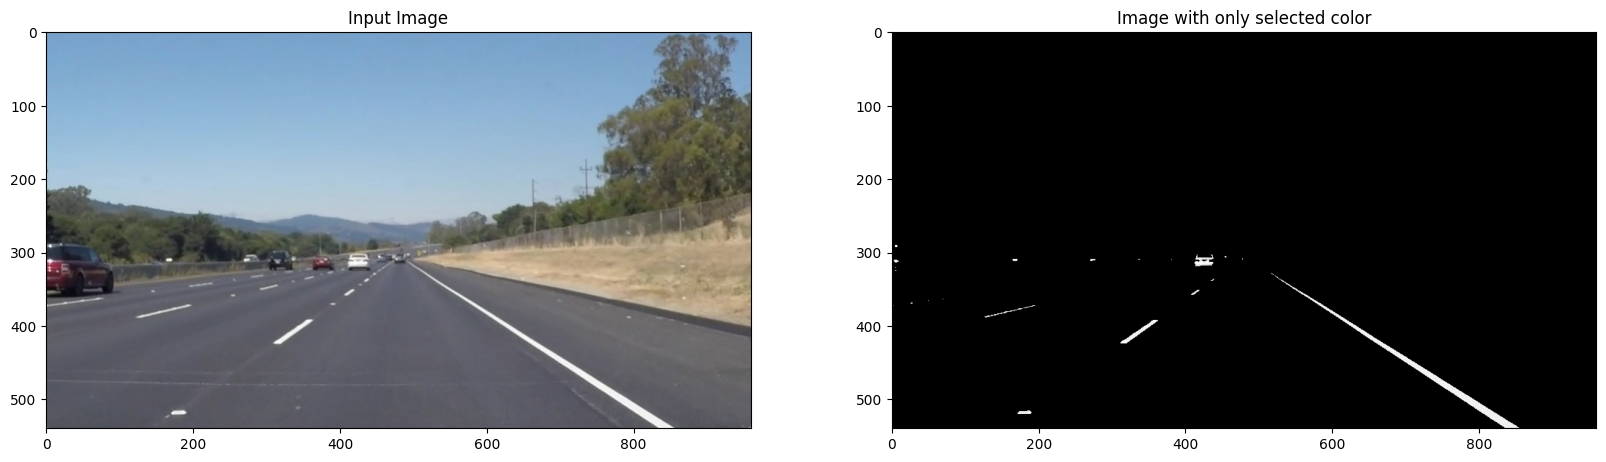

In [2]:
# Define color selection criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Now lets test this on an image
# Read in the image
image = mpimg.imread('data/test_images/solidWhiteRight.jpg')

# Make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
image_selected_color = np.copy(image)
image_selected_color

# Get all the pixels from the image where the RBG value is lower than our threshold 
thresholds = (image[:,:,0] < rgb_threshold[0]) | (image[:,:,1] < rgb_threshold[1]) | (image[:,:,2] < rgb_threshold[2])

# Remove all the colors apart from our selected colors
image_selected_color[thresholds] = [0,0,0]

# Display the image
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,2,1)
plt.imshow(image)
ax.set_title("Input Image")

ax = fig.add_subplot(1,2,2)
plt.imshow(image_selected_color)
ax.set_title("Image with only selected color")

plt.show()



In the above output we can clearly see the lane lines

##### ii. Region Masking  
Here we will assume that the camera is kept at the same position and at any point in time, the position of road lane lines are more or less static. Using this, we will select our region of interest where the road lane lines will always appear. We can consider this region as triangle for simplicity. For more accurate result, we can a quadrilateral or a polygon. <br>
We will use the above output image to apply the region

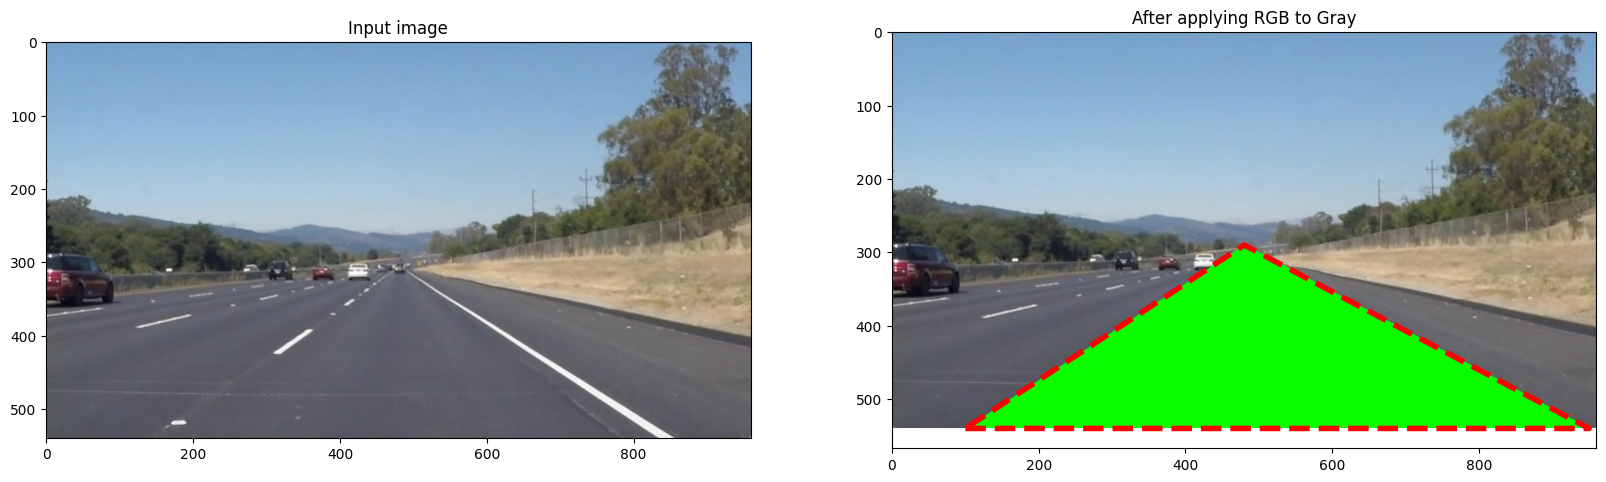

In [3]:
# Lets define the vertices of a triangle to select region of interest.
# We know that the origin (x=0, y=0) is in the upper left

left_bottom = [100, 540]
right_bottom = [950, 540]
apex = [480, 290]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & (YY > (XX*fit_right[0] + fit_right[1])) & (YY < (XX*fit_bottom[0] + fit_bottom[1]))

image_selected_region = np.copy(image)
                    
# Mask region selection
# Color pixels red where region selections met
image_selected_region[region_thresholds] = [9, 255, 0]

# Show original image
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,2,1)
plt.imshow(image)
ax.set_title("Input image")

# Show masked region image
ax = fig.add_subplot(1,2,2)
plt.imshow(image_selected_region)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
ax.set_title("After applying RGB to Gray")

plt.show()




#### 2. Detect lane lines using OpenVC
##### i. Grayscale
We'll convert the colored image to grayscale

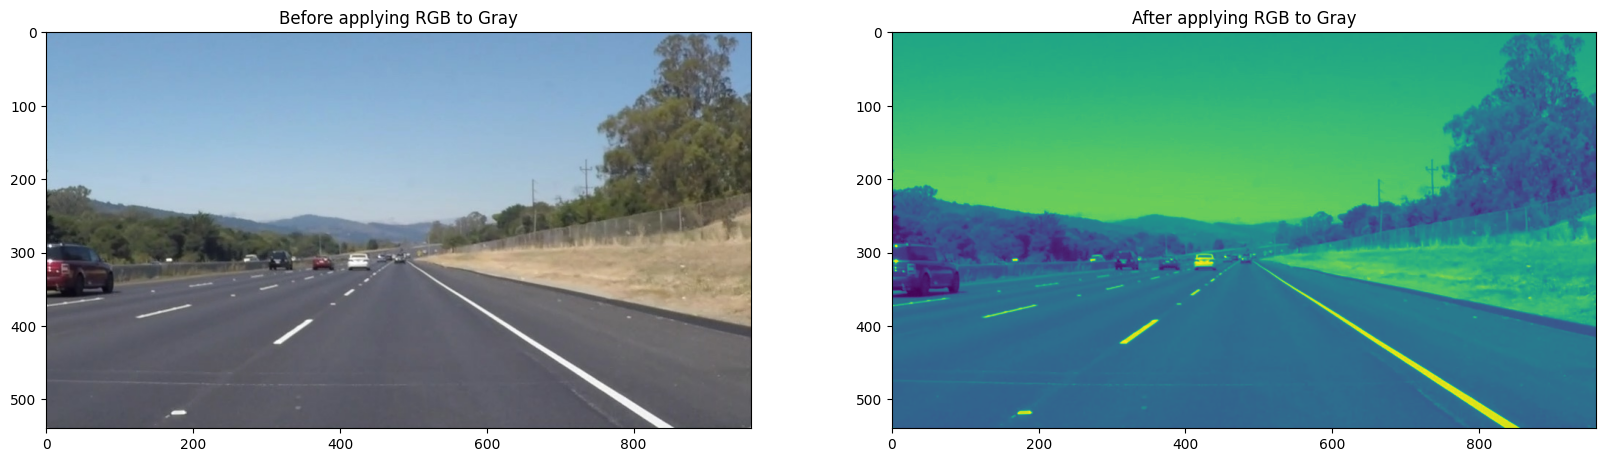

In [4]:
# Read in the image and convert to grayscale
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Display the image
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,2,1)
plt.imshow(image)
ax.set_title("Before applying RGB to Gray")

ax = fig.add_subplot(1,2,2)
plt.imshow(gray)
ax.set_title("After applying RGB to Gray")

plt.show()

##### ii. Gaussian Blur
This is a way of suppressing noise and spurious gradients by averaging. 

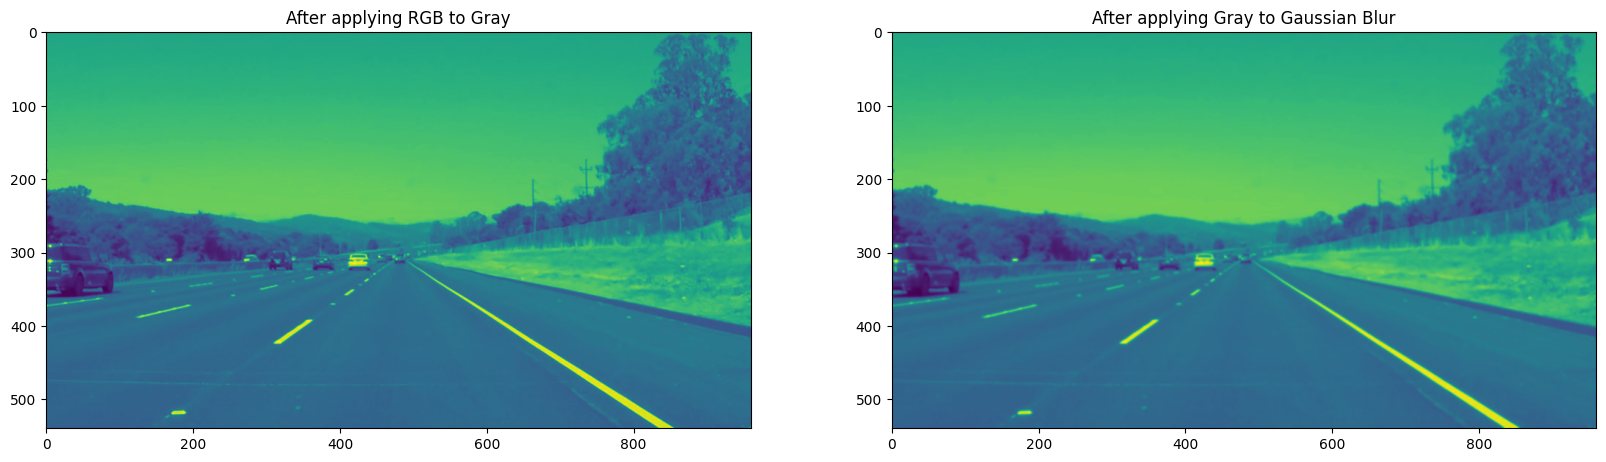

In [5]:
# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Display the image
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,2,1)
plt.imshow(gray)
ax.set_title("After applying RGB to Gray")

ax = fig.add_subplot(1,2,2)
plt.imshow(blur_gray)
ax.set_title("After applying Gray to Gaussian Blur")

plt.show()


##### iii. Canny Edge Detection
Based on thresholds, this will detect edges and return another another with only edges. We will use 2 thresholds - high_threshold & low_threshold. The algorithm will first detect strong edges pixels above the high_threshold, and reject weak edges pixels below the low_threshold.<br>

Since our image is already in grayscale, each pixel has 256 possible values. 

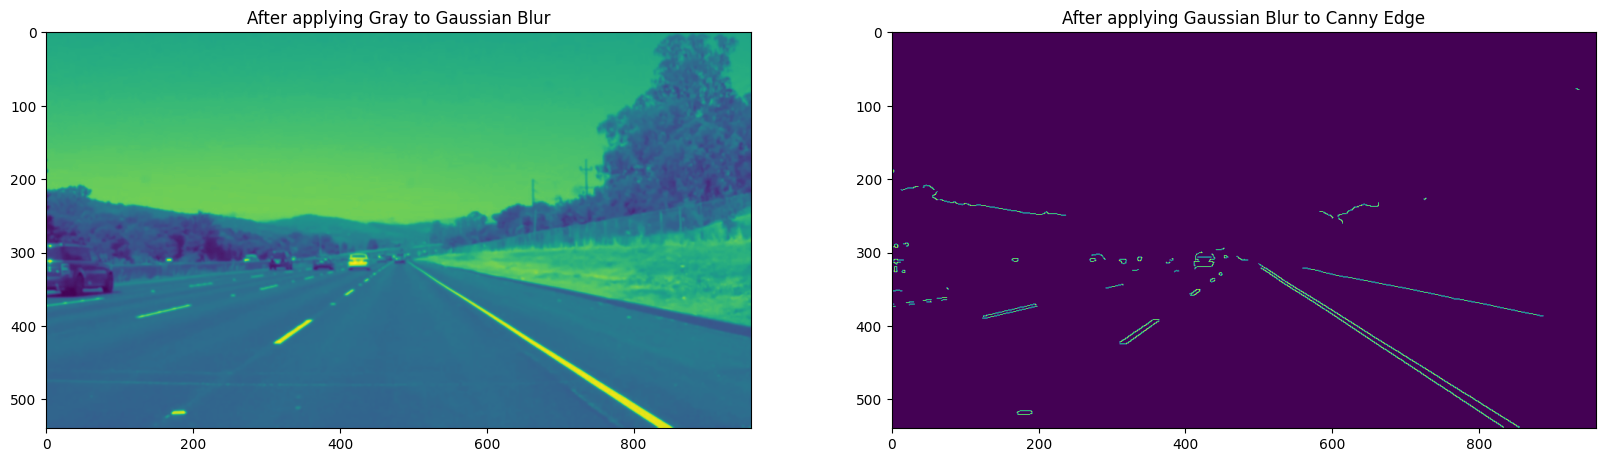

In [6]:
# Define our parameters for Canny and run it
low_threshold = 180
high_threshold = 240
canny_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
fig = plt.figure(figsize=(20,6))

ax = fig.add_subplot(1,2,1)
plt.imshow(blur_gray)
ax.set_title("After applying Gray to Gaussian Blur")

ax = fig.add_subplot(1,2,2)
plt.imshow(canny_edges)
ax.set_title("After applying Gaussian Blur to Canny Edge")

plt.show()

##### iv.Hough Transform 
In image space, a line is plotted as x vs. y, but in 1962, Paul Hough devised a method for representing lines in parameter space, which we will call “Hough space” in his honor.

In Hough space, I can represent my "x vs. y" line as a point in "m vs. b" instead. The Hough Transform is just the conversion from image space to Hough space. So, the characterization of a line in image space will be a single point at the position (m, b) in Hough space. References (https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

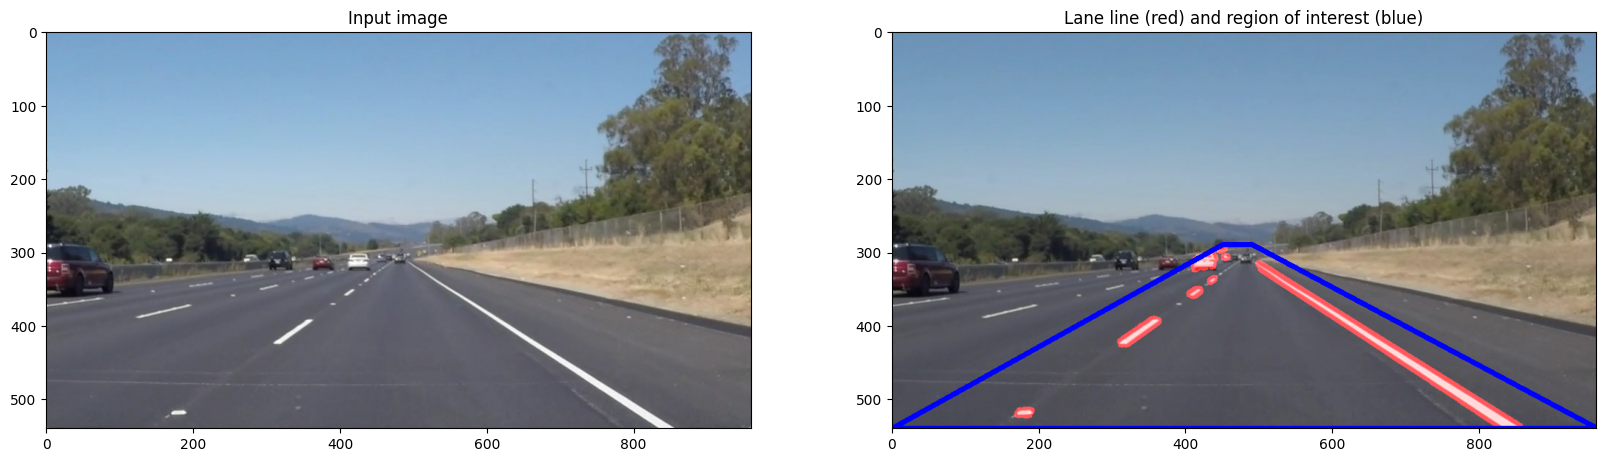

In [7]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(canny_edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(canny_edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_canny_edges = np.dstack((canny_edges, canny_edges, canny_edges)) 

# Draw the lines on the edge image
lines_canny_edges = cv2.addWeighted(image, 0.9, line_image, 1, 0) # To display original image
lines_canny_edges = cv2.polylines(lines_canny_edges,vertices, True, (0,0,255), 5) # To display blue outlines

# Display the image
fig = plt.figure(figsize=(20,6))

ax = fig.add_subplot(1,2,1)
plt.imshow(image)
ax.set_title("Input image")

ax = fig.add_subplot(1,2,2)
plt.imshow(lines_canny_edges)
ax.set_title("Lane line (red) and region of interest (blue)")

plt.show()

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
    #cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    #print(poly_vertices)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [9]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

#### 3. Apply on different test images

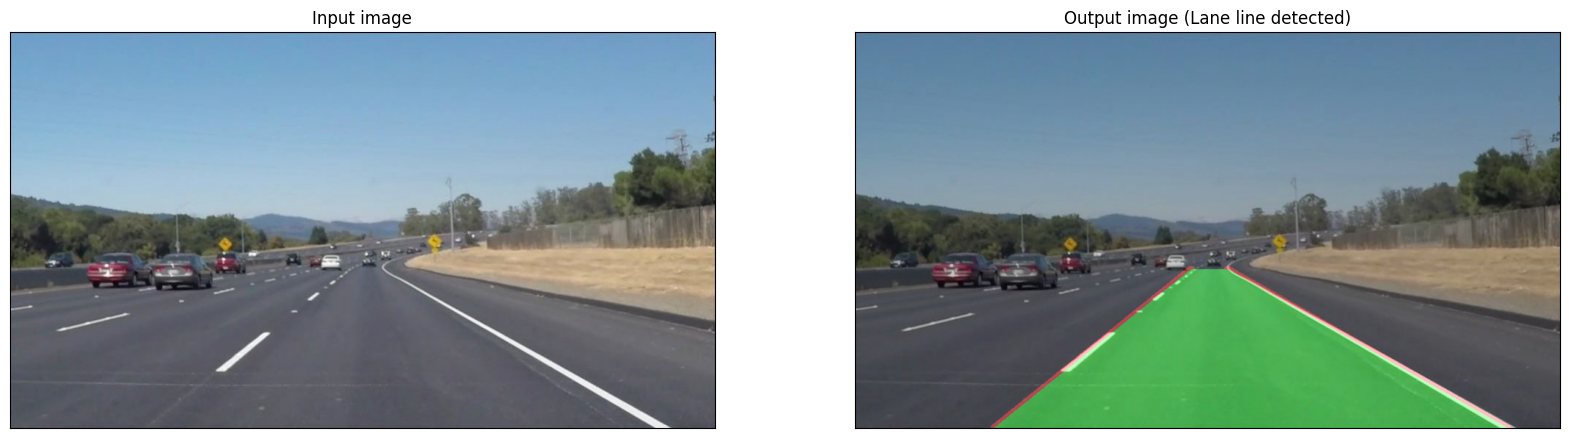

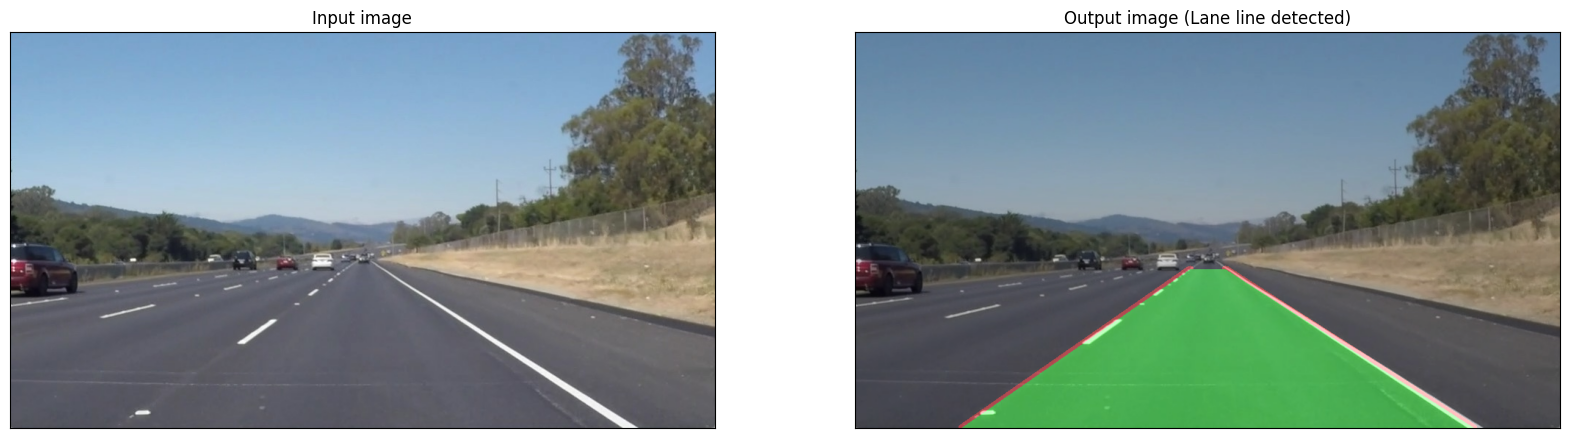

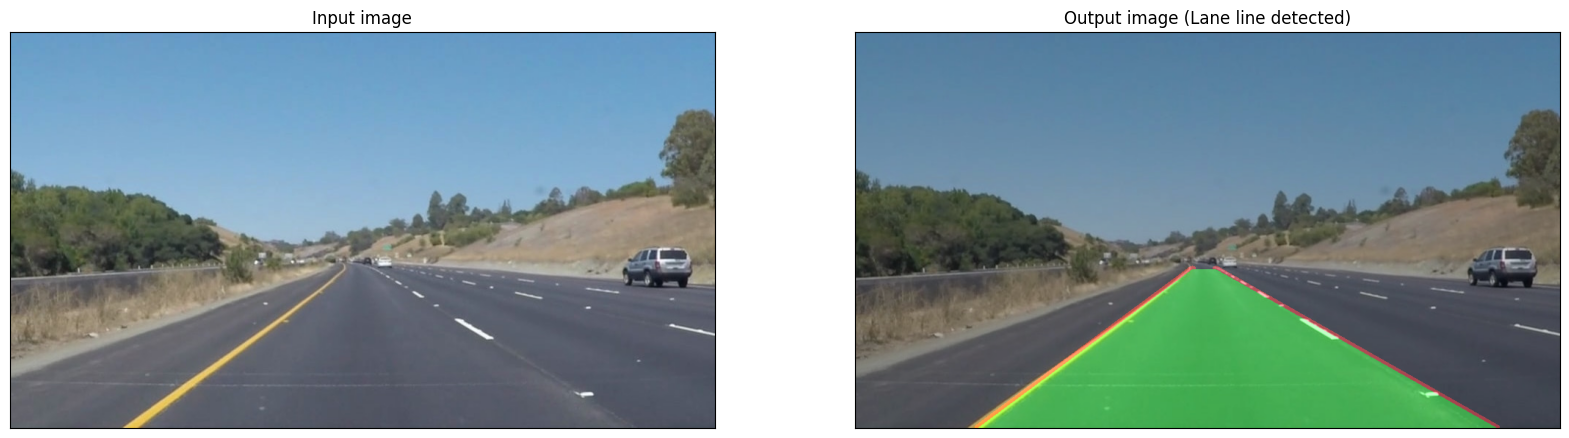

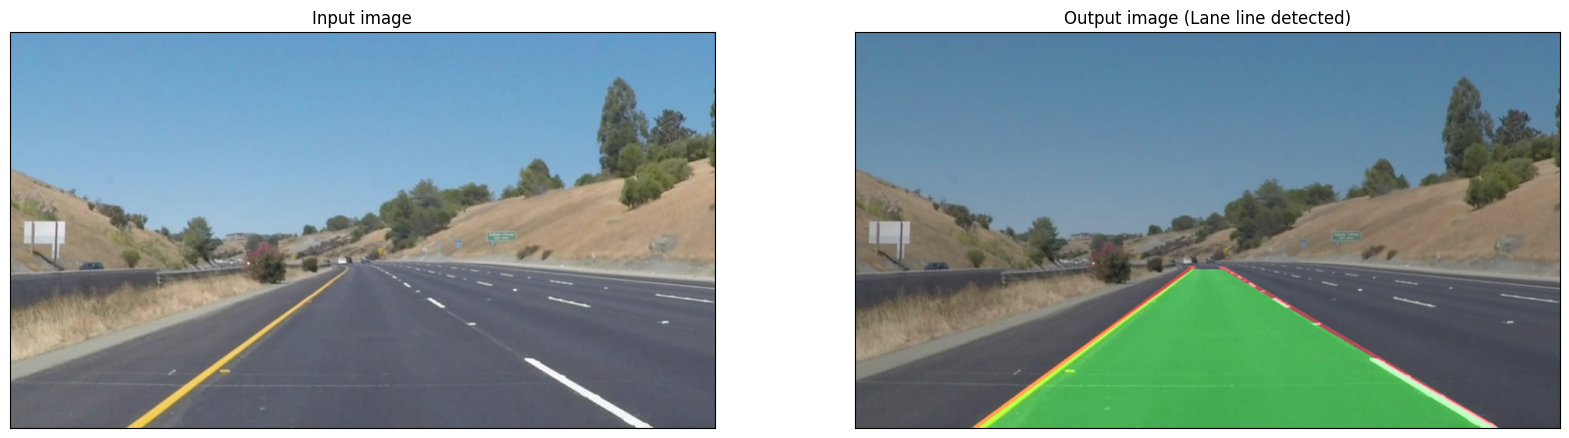

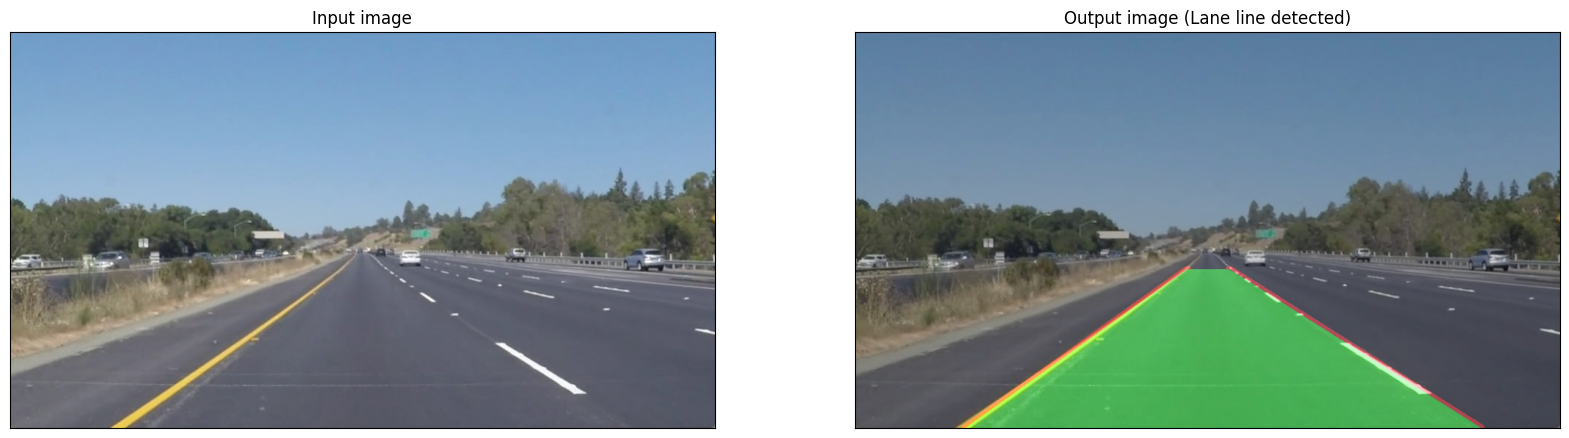

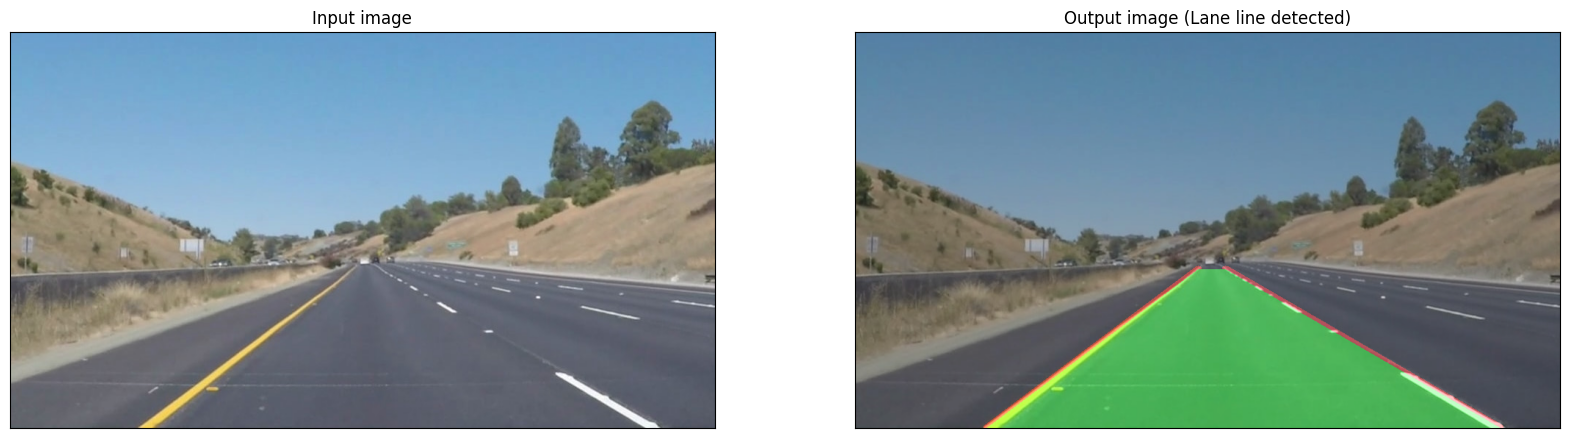

In [10]:
for image_path in list(os.listdir('./data/test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./data/test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image))
    ax.set_title("Output image (Lane line detected)")
    plt.show()

#### 4. Apply on Singapore road lane image

In [15]:
print('To add after taking real pictures')

To add after taking real pictures


#### 5. Apply on the video

In [12]:
white_output = './data/output/solidWhiteRight.mp4'
# To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# To do so add .subclip(start_second,end_second) to the end of the line below
# Where start_second and end_second are integer values representing the start and end of the subclip
# You may also uncomment the following line for a subclip of the first 5 seconds
# e.g. clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(50,60) 

clip1 = VideoFileClip("data/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 2/221 [00:27<49:53, 13.67s/it, now=None]

Moviepy - Building video ./data/output/solidWhiteRight.mp4.
Moviepy - Writing video ./data/output/solidWhiteRight.mp4



t:   1%|          | 2/221 [00:31<57:44, 15.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready ./data/output/solidWhiteRight.mp4
CPU times: total: 2.89 s
Wall time: 4.31 s


##### Output Video

In [14]:
HTML("""
<video width="600" height="300" controls>
  <source src="{0}">
</video>
""".format(white_output))

#### 6. Apply on Singapore road lane video

In [15]:
print('Coming soon...')

Coming soon...
